In [1]:
!pip3 install numpy==1.26.4


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip


In [1]:
import math
import pickle as pkl

from tqdm import tqdm
tqdm.pandas()

import yaml
import pandas as pd
import numpy as np
from numpy import triu
from nltk.tokenize import word_tokenize, TweetTokenizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [14]:
import nltk 
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
# Read in the processed data and the processed inbound dataset 
processed_df = pd.read_pickle("../data/processed/processed_v2.pkl")
processed_inbound_extra = processed_df["clean_inbound_text"]
processed_inbound_extra.head()

4     different people have given different answers ...
5     way to drop the ball on customer service so pi...
6     i want my amazon payments account closed dm me...
9     yeah this is crazy were less than a week away ...
10    how about you guys figure out my xbox one x pr...
Name: clean_inbound_text, dtype: object

In [15]:
# Reset the index. Set it properly in this iteration 
processed_df = processed_df.reset_index(drop=True)
processed_inbound_extra = processed_inbound_extra.reset_index(drop=True)

In [5]:
# Check for some null values 
processed_df.isnull().sum()

inbound_text               0
author_id                  0
created_at                 0
outbound_text              0
response_tweet_id      60327
inbound_lang               0
inbound_hashtags           0
outbound_hashtags          0
clean_inbound_text         0
clean_outbound_text        0
outbound_tokens_pos        0
inbound_tokens_pos         0
dtype: int64

In [16]:
# Read in the intents back 
with open(r"../objects/intents_amazon_support.yml") as file:
    intents = yaml.load(file, Loader=yaml.FullLoader)

# Previewing
print(f'\nintents:\n{intents}')
print(f'\nprocessed:\n{processed_df.head()}')


intents:
{'track': ['tracking', 'order', 'shipment', 'late', 'status', 'carrier', 'update', 'number', 'info', 'received', 'details'], 'support': ['service'], 'quality': ['quality', 'product', 'damaged', 'received', 'refund', 'return', 'issue', 'order', 'packaging', 'proper', 'working', 'expected', 'different'], 'discount': ['prime', 'product', 'offer', 'price', 'sale'], 'account': ['email', 'orders', 'details', 'bank', 'access']}

processed:
                                        inbound_text   author_id  \
0  @AmazonHelp 3 different people have given 3 di...  AmazonHelp   
1  Way to drop the ball on customer service @1158...  AmazonHelp   
2  @115823 I want my amazon payments account CLOS...  AmazonHelp   
3  @AmazonHelp @115826 Yeah this is crazy we’re l...  AmazonHelp   
4  @115828 How about you guys figure out my Xbox ...  AmazonHelp   

                  created_at  \
0  2017-10-31 23:28:00+00:00   
1  2017-10-31 22:29:00+00:00   
2  2017-10-31 22:28:34+00:00   
3  2017-11-01 12

## Tweet Collection with Doc2Vec 
I can use my Doc2Vec representation to find top 1000 Tweets most similar to a generalized intent version of a Tweet based on it's cosine similarity. 

Heuristic search refers to a search strategy that attempts to optimize a problem by iteratively improving the solution based on a given heuristic function or a cost measure. My cost measure is trying to get the closest cosine distances.

So I basically trained my doc2vec model with my training data, which is the `processed_inbound`. I can actually compute a vector based on my training data to vectorize that word.

## Training my Doc2Vec 

### Data Synthesis 
Basically, there are 2 ways I can get my current training data (1000 for each)
* **Doc2Vec:** Some intent examples I will synthetically generate from an idealized example using doc2vec
* **Manual:** Some intent examples I will synthetically generate by duplicating and manual (like greeting, because the current data does not represent this)
* **Hybrid:** Some intents I will do a hybrid approach, where 50 percent might be my generated data, and 50 percent might be 

In [1]:
#TODO: Add information about Doc2Vec or post a link to it over here 

In [17]:
# Creating a synthetic dataset - generating N Tweets resembling a mock tweet
# This will subsequently be merged with the existing inbound data for inclusion in the doc2vec training process

# Version 1 - will be improved in future iterations
ideal = {
            "order track": "@AmazonHelo Hi, could you provide an update on the order? Its been days since the product has moved from its last location ", # change intent to "order tracking"???
            "product inquiry": "@AmazonHelp Looking for more info on the product. Can you share details or direct me to a reliable source?", # product inquire??? 
            "return refund": "@AmazonHelp How can I start a return process? The item I received doesn't match the description.",
            "account management": "@AmazonHelp Hi, I am having trouble logging into my account. Can you help me reset my password?", 
            "promotion discount": "@AmazonHelp Are there any ongoing promotions or deals in the ongoing festive season? Looking to buy a few items.",
            "shipping": "@AmazonHelp Hi, My address has changed. Can you help me update the shipping address for my order?",
            "technical support": "@AmazonHelp Encountering errors during checkout. Can you help me troubleshoot the issue?",
            "payment issue": "@AmazonHelp My payment method isn't going through. Any suggestions on how to resolve this?",
            "general query": "@AmazonHelp Hi, I have a general question regarding the product. Can you help me with this?"
        }

# Version 2 - Here I will try writing some more intent items 
ideal_tag_dict = {
                    "track": "tracking order shipoment late status carrier update number info received details", 
                    "support": "support chat customer resolution feedback satisfaction",
                    "quality": "quality product damaged received refund return issue order packaging proper working expected different", 
                    "discount": "prime product offer price sale", 
                    "account": "email orders details bank access"
                }

In [18]:
def add_extra(clean_inbound_text, extra_tweets):
    '''Adding extra tweets to the current tokenized data'''
    
    # Convert the extra tweets into a pandas Series
    extra_tweets = pd.Series(extra_tweets)

    ## The following 2 steps aren't required for now as the data is already in string format 
    ## Convert the extra tweets into a single string
    # print("Converting to string...")
    # string_processed_data = current_tokenized_data.progress_apply(" ".join)

    # Concatenate the extra tweets to the current data
    clean_inbound_text = pd.concat([clean_inbound_text, extra_tweets], axis = 0, ignore_index = True)

    # Tokenize the combined data
    tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)
    print("Tokenizing...")
    tokenized_data = clean_inbound_text.progress_apply(tknzr.tokenize)
    string_processed_data = tokenized_data.progress_apply(" ".join)

    return string_processed_data

# Add the extra tweets to the current data
processed_inbound_extra = add_extra(processed_df["clean_inbound_text"], list(ideal_tag_dict.values()))

# Save the updated data to a pickle file
processed_inbound_extra.to_pickle("../objects/processed_inbound_extra.pkl")

processed_inbound_extra

Tokenizing...


100%|██████████| 122345/122345 [00:00<00:00, 2089832.59it/s]


0         different people have given different answers ...
1         way to drop the ball on customer service so pi...
2         i want my amazon payments account closed dm me...
3         yeah this is crazy were less than a week away ...
4         how about you guys figure out my xbox one x pr...
                                ...                        
122340    tracking order shipoment late status carrier u...
122341    support chat customer resolution feedback sati...
122342    quality product damaged received refund return...
122343                       prime product offer price sale
122344                     email orders details bank access
Length: 122345, dtype: object

In [76]:
processed_inbound_extra[-7:]

122338    no exchange available for i need to exchange m...
122339    there should be bonus and gifts for regular cu...
122340    tracking order shipoment late status carrier u...
122341    support chat customer resolution feedback sati...
122342    quality product damaged received refund return...
122343                       prime product offer price sale
122344                     email orders details bank access
dtype: object

In [77]:
processed_inbound_extra.shape

(122345,)

In [78]:
# Train a Doc2Vec model on the entire corpus 
def train_doc2vec(string_data, max_epochs, vec_size, alpha):
     
    # Tagging each of the documents with a unique ID
    tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(string_data)]
    
    # Instantiating my model 
    model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1) # dm=1 means 'distributed memory' (PV-DM)
    
    # Building the vocabulary table
    model.build_vocab(tagged_data)
    
    for epoch in range(max_epochs): # Run for max_epochs
        print('iteration {0}'.format(epoch))    
        model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs) # This statement trains the model on the current epoch
        # Decreasing the learning rate
        model.alpha -= 0.0002
        # Fixing the learning rate, no decay
        model.min_alpha = model.alpha
        
    # Saving model
    model.save("../models/d2v.model")
    print("Model Saved")        
    
# Training
train_doc2vec(processed_inbound_extra, max_epochs=100, vec_size=20, alpha=0.025)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1281c9370>>
Traceback (most recent call last):
  File "/Users/saggysimmba/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


iteration 0


In [19]:
# Loading in the Doc2Vec model 
model = Doc2Vec.load("../models/d2v.model")

# Storing all inbound data into a list for clustering 
inbound_d2v = np.array([model.infer_vector(word_tokenize(_d.lower())) for _d in list(processed_inbound_extra)])

# Saving
with open("../objects/inbound_d2v.pkl", "wb") as f:
    pkl.dump(inbound_d2v, f)

In [10]:
inbound_d2v.shape

(122345, 20)

Before, we did not have a concept of distance in our vectorizers, they don't really have a specific meaning. This is a much better way because it captures the contextual representations between words! Now the clustering should be a lot better than tfidf or bag of words.

## Methodology

Initially, to get the top 1000 similar Tweets, I tried using the existing data. But I don't think that would yield the most accurate results because I am not capturing the best representative Tweet for an intent. For that reason, I made all these base representative Tweets myself (as seen in the values derived from `ideal` dict above). The goal is to find trying to find an idealized, wholistic representation of an intent. Then from there I use my doc2vec representations to find the top 1000 tweets most similar based on cosine similarity.

### Package Exploration

In [20]:
## Trying an example 
## Finding and making idealized versions of each tweet so that I can 
intents_eg = {"discount": ["prime", "product", "offer", "price", "sale"]}
inferred_vectors = []

for keywords in intents_eg.values():
    inferred_vectors.append(model.infer_vector(intents_eg))
    
inferred_vectors

[array([ 0.10244738,  0.06004954,  0.00603363, -0.04262464, -0.00291941,
        -0.03927179,  0.03872953,  0.0150747 ,  0.10866123,  0.02787331,
         0.00715166, -0.08840131, -0.01201261, -0.0265836 , -0.05975816,
         0.12689796, -0.00516903,  0.04469115, -0.04072769, -0.01096257],
       dtype=float32)]

In [11]:
#TODO: My Doc2Vec model vector is inferring different vector values for a given sample. I think I need to treat the model in a better fashion later on  

In [21]:
intents.values()

dict_values([['tracking', 'order', 'shipment', 'late', 'status', 'carrier', 'update', 'number', 'info', 'received', 'details'], ['service'], ['quality', 'product', 'damaged', 'received', 'refund', 'return', 'issue', 'order', 'packaging', 'proper', 'working', 'expected', 'different'], ['prime', 'product', 'offer', 'price', 'sale'], ['email', 'orders', 'details', 'bank', 'access']])

In [22]:
# These are the current intents I wish to add to my training data 
print(intents) 

# Concatenate all the intent values in a sentence form 
ideal_values = list(" ".join(_words) for _words in intents.values())


{'track': ['tracking', 'order', 'shipment', 'late', 'status', 'carrier', 'update', 'number', 'info', 'received', 'details'], 'support': ['service'], 'quality': ['quality', 'product', 'damaged', 'received', 'refund', 'return', 'issue', 'order', 'packaging', 'proper', 'working', 'expected', 'different'], 'discount': ['prime', 'product', 'offer', 'price', 'sale'], 'account': ['email', 'orders', 'details', 'bank', 'access']}


I have chosen my intent value tokens based on the frequency count of words as described in the previous notebooks. If performance is not upto the mark, reiterate and improve upon them in the future version(s)

### Finding intent tags 
I want to get the tags of my representative Tweets because that's what doc2vec's `model.similarity` method takes in as paramater to generate top N Tweets similar to it.

In [14]:
#TODO: Improve this block of code later - The following code block isn't the most efficient one

In [23]:
intents.items()

dict_items([('track', ['tracking', 'order', 'shipment', 'late', 'status', 'carrier', 'update', 'number', 'info', 'received', 'details']), ('support', ['service']), ('quality', ['quality', 'product', 'damaged', 'received', 'refund', 'return', 'issue', 'order', 'packaging', 'proper', 'working', 'expected', 'different']), ('discount', ['prime', 'product', 'offer', 'price', 'sale']), ('account', ['email', 'orders', 'details', 'bank', 'access'])])

In [24]:
tokenizer = TweetTokenizer(strip_handles = True, reduce_len = True)

intents_repr = {k: tokenizer.tokenize(v) for k, v in ideal_tag_dict.items()}
print(intents_repr)

# Save them into objects 
with open("../objects/intents_repr.yml", "w") as f:
    yaml.dump(intents_repr, f, default_flow_style=False)

# Storing tags in order of the dictionary above
# tags = []

# Tokenize and process inbound tweets 
tokenized_processed_inbound_extra = processed_inbound_extra.apply(tokenizer.tokenize)

{'track': ['tracking', 'order', 'shipoment', 'late', 'status', 'carrier', 'update', 'number', 'info', 'received', 'details'], 'support': ['support', 'chat', 'customer', 'resolution', 'feedback', 'satisfaction'], 'quality': ['quality', 'product', 'damaged', 'received', 'refund', 'return', 'issue', 'order', 'packaging', 'proper', 'working', 'expected', 'different'], 'discount': ['prime', 'product', 'offer', 'price', 'sale'], 'account': ['email', 'orders', 'details', 'bank', 'access']}


In [18]:
processed_df

,inbound_text,author_id,created_at,outbound_text,response_tweet_id,inbound_lang,inbound_hashtags,outbound_hashtags,clean_inbound_text,clean_outbound_text,outbound_tokens_pos,inbound_tokens_pos
4,@AmazonHelp 3 different people have given 3 di...,AmazonHelp,2017-10-31 23:28:00+00:00,@115820 We'd like to take a further look into ...,619,en,[],[],different people have given different answers ...,wed like to take a further look into this with...,"[-PRON-: NOUN, d: VERB, like: VERB, to: NOUN, ...","[different: NOUN, people: NOUN, have: NOUN, gi..."
5,Way to drop the ball on customer service @1158...,AmazonHelp,2017-10-31 22:29:00+00:00,@115820 I'm sorry we've let you down! Without ...,616,en,[],[],way to drop the ball on customer service so pi...,i am sorry we have let you down without provid...,"[i: NOUN, be: NOUN, sorry: NOUN, -PRON-: NOUN,...","[way: NOUN, to: NOUN, drop: VERB, the: NOUN, b..."
6,@115823 I want my amazon payments account CLOS...,AmazonHelp,2017-10-31 22:28:34+00:00,@115822 I am unable to affect your account via...,NaN,en,[],[],i want my amazon payments account closed dm me...,i am unable to affect your account via twitter...,"[i: NOUN, be: NOUN, unable: NOUN, to: NOUN, af...","[i: NOUN, want: VERB, -PRON-: NOUN, amazon: NO..."
9,@AmazonHelp @115826 Yeah this is crazy we’re l...,AmazonHelp,2017-11-01 12:53:34+00:00,@115827 Thanks for your patience. ^KM,NaN,en,[],[],yeah this is crazy were less than a week away ...,thanks for your patience km,"[thank: NOUN, for: NOUN, -PRON-: NOUN, patienc...","[yeah: NOUN, this: NOUN, be: NOUN, crazy: NOUN..."
10,@115828 How about you guys figure out my Xbox ...,AmazonHelp,2017-10-31 22:28:00+00:00,@115826 I'm sorry for the wait. You'll receive...,627,en,[],[],how about you guys figure out my xbox one x pr...,i am sorry for the wait you will receive an em...,"[i: NOUN, be: NOUN, sorry: NOUN, for: NOUN, th...","[how: NOUN, about: NOUN, -PRON-: NOUN, guy: NO..."
...,...,...,...,...,...,...,...,...,...,...,...,...
168803,@AmazonHelp I sent you guys a DM regarding the...,AmazonHelp,2017-11-22 00:17:00+00:00,@328597 We're unable to access customer accoun...,NaN,en,[],[],i sent you guys a dm regarding the status of m...,were unable to access customer accounts via so...,"[be: NOUN, unable: NOUN, to: NOUN, access: VER...","[i: NOUN, send: VERB, -PRON-: NOUN, guy: NOUN,..."
168805,This is happening in my area w/@115821 “Prime”...,AmazonHelp,2017-11-22 02:16:55+00:00,"@777901 I'm sorry for the delay, Brenda! We st...",2987557,en,[],[],this is happening in my area w prime deliverie...,i am sorry for the delay brenda we strive to s...,"[i: NOUN, be: NOUN, sorry: NOUN, for: NOUN, th...","[this: NOUN, be: NOUN, happen: VERB, in: NOUN,..."
168807,@132994 @132995 @115850 got my #OnePlus5T at 8...,AmazonHelp,2017-11-22 03:49:29+00:00,@823783 Woohoo! That's awesome! Hope you love ...,2987674,en,"[#AmazonPrime, #OnePlus5T]",[],got my at am thanks for fulfilling the order fast,woohoo that is awesome hope you love the phone js,"[woohoo: NOUN, that: NOUN, be: NOUN, awesome: ...","[get: VERB, -PRON-: NOUN, at: NOUN, be: NOUN, ..."
168812,@115850 @132994 No exchange available for #One...,AmazonHelp,2017-11-22 05:22:31+00:00,@823802 The Exchange Offer is currently availa...,NaN,en,[#OnePlus5T],[],no exchange available for i need to exchange m...,the exchange offer is currently available only...,"[the: NOUN, exchange: NOUN, offer: NOUN, be: N...","[no: NOUN, exchange: NOUN, available: NOUN, fo..."


In [18]:
processed_inbound_extra 

0         different people have given different answers ...
1         way to drop the ball on customer service so pi...
2         i want my amazon payments account closed dm me...
3         yeah this is crazy were less than a week away ...
4         how about you guys figure out my xbox one x pr...
                                ...                        
122335    i sent you guys a dm regarding the status of m...
122336    this is happening in my area w prime deliverie...
122337    got my at am thanks for fulfilling the order fast
122338    no exchange available for i need to exchange m...
122339    there should be bonus and gifts for regular cu...
Name: clean_inbound_text, Length: 122340, dtype: object

In [68]:
tokenized_processed_inbound_extra

0         [different, people, have, given, different, an...
1         [way, to, drop, the, ball, on, customer, servi...
2         [i, want, my, amazon, payments, account, close...
3         [yeah, this, is, crazy, were, less, than, a, w...
4         [how, about, you, guys, figure, out, my, xbox,...
                                ...                        
122335    [i, sent, you, guys, a, dm, regarding, the, st...
122336    [this, is, happening, in, my, area, w, prime, ...
122337    [got, my, at, am, thanks, for, fulfilling, the...
122338    [no, exchange, available, for, i, need, to, ex...
122339    [there, should, be, bonus, and, gifts, for, re...
Name: clean_inbound_text, Length: 122340, dtype: object

In [25]:
# Find the index locations of specific Tweets
# get_indices = []
# Storing tags in order of the dictionary above
tags = []
def report_index_loc(tweet, intent_name):
    ''' Takes in the tweet to find the index for and returns a report of that tweet index along with what the 
    representative Tweet looks like'''
    try:
        tweets = [] # List which stores tuples of indexes of representative tweets AND a boolean value to indicate if the tweet has the intent we are looking for
        for i, j in enumerate(tokenized_processed_inbound_extra):
            if j == tweet:
                tweets.append((i, True))
            else:
                tweets.append((i, False))

        indices = [i[0] for i in tweets if i[1] == True]
        # get_indices.append(indices.append(i[0]) if i[1] == True else False for i in tweets)

        preview = processed_inbound_extra.iloc[indices]

        # Appending to indexes for dictionary 
        tags.append(str(indices[0]))
        print(tags)
        

    except IndexError as e:
        print("Index not in list, move on")
        return

    return intent_name, str(indices[0]), preview


# Reporting and storing indexes with the function
print("TAGGED INDEXES TO LOOK FOR")
for j, i in intents_repr.items():
    try:
        print('\n{} \nIndex: {}\nPreview: {}'.format(*report_index_loc(i, j)))
    except Exception as e:
        print("Index ended")

TAGGED INDEXES TO LOOK FOR
['122340']

track 
Index: 122340
Preview: 122340    tracking order shipoment late status carrier u...
dtype: object
['122340', '122341']

support 
Index: 122341
Preview: 122341    support chat customer resolution feedback sati...
dtype: object
['122340', '122341', '122342']

quality 
Index: 122342
Preview: 122342    quality product damaged received refund return...
dtype: object
['122340', '122341', '122342', '122343']

discount 
Index: 122343
Preview: 122343    prime product offer price sale
dtype: object
['122340', '122341', '122342', '122343', '122344']

account 
Index: 122344
Preview: 122344    email orders details bank access
dtype: object


In [13]:
tokenized_processed_inbound_extra

4         [different, people, have, given, different, an...
5         [way, to, drop, the, ball, on, customer, servi...
6         [i, want, my, amazon, payments, account, close...
9         [yeah, this, is, crazy, were, less, than, a, w...
10        [how, about, you, guys, figure, out, my, xbox,...
                                ...                        
168803    [i, sent, you, guys, a, dm, regarding, the, st...
168805    [this, is, happening, in, my, area, w, prime, ...
168807    [got, my, at, am, thanks, for, fulfilling, the...
168812    [no, exchange, available, for, i, need, to, ex...
168817    [there, should, be, bonus, and, gifts, for, re...
Name: clean_inbound_text, Length: 122340, dtype: object

In [21]:
intents_repr

{'track': ['tracking',
  'order',
  'shipoment',
  'late',
  'status',
  'carrier',
  'update',
  'number',
  'info',
  'received',
  'details'],
 'support': ['support',
  'chat',
  'customer',
  'resolution',
  'feedback',
  'satisfaction'],
 'quality': ['quality',
  'product',
  'damaged',
  'received',
  'refund',
  'return',
  'issue',
  'order',
  'packaging',
  'proper',
  'working',
  'expected',
  'different'],
 'discount': ['prime', 'product', 'offer', 'price', 'sale'],
 'account': ['email', 'orders', 'details', 'bank', 'access']}

In [73]:
tokenized_processed_inbound_extra[39500]

['tampered',
 'supplied',
 'defective',
 'fake',
 'faileddetectonline',
 'help',
 'identified',
 'fake',
 'cartridges']

In [67]:
inferred_vector = model.infer_vector(tokenized_processed_inbound_extra[122342])
inferred_vector

array([ 0.2575036 ,  0.22525875, -0.00204794,  0.25034946,  0.29573932,
        0.11042561,  0.34600645, -0.09492776,  0.8735179 ,  0.04850508,
       -0.08035677, -0.60845906, -0.51485014, -0.52978706,  0.02381231,
        0.2749139 , -0.03704822,  0.13280009, -0.03495918, -0.09525312],
      dtype=float32)

In [72]:
# Great! Now I can get the training data for an example intent 
similar_doc = model.dv.most_similar([inferred_vector], topn = 2000)
# Preview
similar_doc[99]

('39500', 0.7334545254707336)

In [42]:
# TODO: Data Cleaning pe dhyan dena pdega. Abhi sahi nai hai 

In [44]:
# TODO: Processed inbound extra, there are spelling issues though which needs to be resolved

In [30]:
intents_repr.keys()

dict_keys(['track', 'support', 'quality', 'discount', 'account'])

In [31]:
tags

['122340', '122341', '122342', '122343', '122344']

In [29]:
# Create the intent-tag dictionary by # Dictionary mapping the intent to the row index 
intents_tags = dict(zip(intents_repr.keys(), tags))
intents_tags

{'track': '122340',
 'support': '122341',
 'quality': '122342',
 'discount': '122343',
 'account': '122344'}

In [30]:
# Just separate out those intents which will purely be generated 
intents_tags_subset = {'support': '122341', 'account': '122344'}

## Data Synthesis 
### 1. Adding intents to training data based on similarity 
As can be seen above, the right tuple element is the cosine similarity. We are just taking the top 1000 similar to a base, idealized version of intents (which we based off keywords mostly). **Intents captured: (track + discount + account)**

### 2. Adding the intents manually 
These ones are generated with a different method that is more manual. I will generate as much examples of this as I can, then I brute force it by duplicating it until it reaches 1000 training examples for preserving class balance. **Intents captured: (greeting + goodbye)**

### 3. Adding in the hybrid intents 
I use my Keyword Exploration shown in the previous notebook and find that there is a lot of overlap between **track** and **quality**. So for both I am going to generate a proportion of it using doc2vec, and the rest I will manually insert examples - the idea is to balance overfitting or noise and putting in the correct signal. **Intents captured: (greeting + goodbye)**

In [48]:
#TODO: **One special case might be out of scope, I might get an alternative way to deal with that since I will not be able to generate all examples of that intent.**
#TODO: **See if I might run into this issue**

In [49]:
#TODO: Here's is the catch. Have intent buckets inplace already in place. You would need to supply this to the below function to get your top N tweets corresponding to the current tweet

In [50]:
#TODO: Check for stopwords because I don't want to include them in the manually represented intents. 
#TODO: This is something I would manually tune to the dataframe (for step 2 of the process)

In [54]:
import json

In [31]:
## Getting top n tweets similar to the first tweet 
# This will return a list of tuples (i, j) where i is the index and j is the 
# cosine similarity to the tagged document index 

# Storing all intents in a dataframe 
train = pd.DataFrame()

# Storing tags in order of the dictionary above 
def generate_intent(target, idx_tag): 
    '''Function that maps an index tag to an intent and returns nsim number of similar tweets'''
    sim_docs = model.dv.most_similar(idx_tag, topn = target)
    
    # Getting just the indexes 
    indexes = [int(i[0]) for i in sim_docs]
    
    # Actually seeing the top 1000 tweets similar to 0th tweet which seems to be about updates 
    # print(processed_inbound_extra[indexes])
    # Adding just the values, AND not the index 
    # Tokenize the tweet 
    return [word_tokenize(tweet) for tweet in list(processed_inbound_extra[indexes].values)]

# Update training data 
for intent_name, tag in intents_tags_subset.items():
    print('Intent: ', intent_name)
    train[intent_name] = generate_intent(1000, tag)
    print('\n')


# 2. Manually added intents 
# These are the remainder intents 
import json
with open("../data/interim/manual_intents_data.json", "r") as f:
    manually_added_intents = json.load(f)

# Insert manually added intents to data 
def insert_manually(target, prototype): 
    ''' Taking a prototype tokenized document to repeat until I get desired length target'''
    factor = math.ceil(target / len(prototype))
    content = prototype * factor
    return [content[i] for i in range(target)]

# Update training data
for intent_name in manually_added_intents["intents"].keys(): 
    train[intent_name] = insert_manually(1000, [*manually_added_intents["intents"][intent_name]])

# 3. Adding in the hybrid intents 
with open("../data/interim/hybrid_intents_data.json", "r") as f:
    hybrid_added_intents = json.load(f)


# 3. Adding in the hybrid intents
def insert_hybrid(manual_target, generated_target, prototype, itag): 
    return insert_manually(manual_target, prototype) + generate_intent(generated_target, itag)

# Update training data
for intent_name in hybrid_added_intents["intents"].keys(): 
    if intent_name == "quality":
        train[intent_name] = insert_hybrid(200, 800, hybrid_added_intents["intents"][intent_name], intents_tags[intent_name])
    else:
        train[intent_name] = insert_hybrid(700, 300, hybrid_added_intents["intents"][intent_name], intents_tags[intent_name])

Intent:  support


Intent:  account




In [ ]:
# TODO: I am not inserting the hybrid intents as of now, since I believe it might just add to unnecessary noise in the dataset. Also, its just complex in the first go. So definitely in 2nd iteration 

In [32]:
# Save the training data to a serialized file
train.to_pickle("../objects/train.pkl")

# Load the train file 
train = pd.read_pickle("../objects/train.pkl")

## Style the display 
show = lambda x: x.head(10).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.map(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'red'}")\
.background_gradient(cmap='Blues')

print(train.shape)
show(train)

(1000, 9)


,support,account,greeting,goodbye,speak_representative,challenge_robot,quality,track,discount
0,"['very', 'poor', 'feedback', 'very', 'disappointing', 'services']","['email', 'account', 'details']",['hi'],['goodbye'],"['talk', 'human', 'please']","['are', 'you', 'a', 'bot']","['product, quality, issue']","['track, my, order']","['offer, discount']"
1,"['already', 'done', 'i', 'am', 'frankly', 'fed', 'up', 'with', 'the', 'support', 'you', 'replies', 'are', 'template', 'replies']","['email', 'account', 'details']",['hello'],['bye'],"['let', 'me', 'talk', 'to', 'support']","['are', 'you', 'real']","['quality, concerns, product, received']","['where, is, my, package']","['sale, discount']"
2,"['very', 'poor', 'feedback', 'very', 'disappointing', 'services']","['email', 'account', 'details']","['what', 'is', 'up']",['thank'],"['can', 'i', 'speak', 'agent', 'person']","['are', 'you', 'an', 'AI']","['received, item, quality, problem']","['locate, my, shipment']","['price, discount']"
3,"['can', 'see', 'you', 'have', 'replied', 'to', 'others', 'who', 'tweeted', 'after', 'me', 'i', 'am', 'a', 'v', 'unhappy', 'prime', 'customer', 'onus', 'on', 'me', 'to', 'go', 'out', 'of', 'my', 'way', 'to', 'return', 'item', 'when', 'wrong', 'item', 'was', 'sent']","['the', 'credit', 'card', 'information', 'is', 'correct']","['good', 'morning']",['thanks'],"['connect', 'me', 'to', 'a', 'human']","['are', 'you', 'a', 'computer']","['need, help, with, product, quality']","['find, my, delivery']","['promotion, discount']"
4,"['my', 'issue', 'is', 'not', 'resolved', 'really', 'should', 'stop', 'business', 'in', 'india']","['account', 'email', 'email']","['good', 'afternoon']",['done'],"['need', 'to', 'speak', 'to', 'a', 'representative']","['who', 'am', 'I', 'talking', 'to']","['product, not, as, expected, quality']","['check, my, order, status']","['deal, discount']"
5,"['everyday', 'following', 'up', 'with', 'you', 'are', 'mail', 'support', 'for', 'past', 'days', 'they', 'kept', 'me', 'on', 'wait', 'and', 'from', 'last', 'couple', 'of', 'days', 'they', 'are', 'not', 'even', 'responding', 'to', 'the', 'mails', 'such', 'a', 'worthless', 'service', 'no', 'one', 'cares']","['my', 'account', 'login', 'is', 'email']","['good', 'evening']","['see', 'you']","['can', 'you', 'put', 'me', 'through', 'to', 'support']","['is', 'this', 'a', 'human']","['how, to, return, poor, quality, item']","['track, my, shipment']","['markdown, discount']"
6,"['i', 'have', 'already', 'written', 'item', 'delivery', 'feedback', 'but', 'no', 'response', 'you', 'have', 'waste', 'rural', 'service', 'than', 'others']","['account', 'email', 'email']","['good', 'night']","['see', 'you', 'later']","['human', 'assistance', 'required']","['am', 'I', 'talking', 'to', 'a', 'person']","['experiencing, quality, issues, with, order']","['where, is, my, order']","['special, discount']"
7,"['care', 'to', 'reply']","['your', 'correspondence', 'does', 'not', 'address', 'the', 'problem', 'i', 'am', 'not', 'interested', 'in', 'knowing', 'why', 'order', 'is', 'delayed', 'just', 'refund', 'my', 'amount', 'without', 'excuse']",['hey'],"['take', 'care']","['i', 'want', 'to', 'talk', 'to', 'a', 'live', 'person']","['are', 'you', 'a', 'real', 'person']","['product, received, quality, is, poor']","['track, my, package']","['bargain, discount']"
8,"['package', 'was', 'delivered', 'at', 'am', 'thanks', 'for', 'your', 'help', 'nonetheless', 'it', 'was', 'not', 'a', 'satisfactory', 'experience', 'after', 'a', 'decade', 'long', 'relationship']","['no', 'emails', 'no', 'reason', 'for', 'delay']",['yo'],['farewell'],"['how', 'can', 'i', 'speak', 'with', 'an', 'agent']","['is', 'this', 'a', 'robot']","['requesting, refund, due, to, poor, quality']","['trace, my, delivery']","['clearance, discount']"
9,"['check', 'out', 'you', 'are', 'mail', 'and', 'my', 'reply', 'below', 'it', 'is', 'a', 'update', 'not', 'resolution', 'i', 'want', 'resolution', 'not', 'excuses']","['customer', 'service', 'just', 'hung', 'up', 'on', '

I am quite pleased with these. They seem quite promising if I inspect them!!!. Just don't worry too much about the preprocessing thing and stuff. I just want my model to be generalizable overall... 

In [33]:
# Convert to long dataframe format from wide so my data can read it 
neat_train = pd.DataFrame(train.T.unstack()).reset_index().iloc[:,1:].rename(columns={"level_1":"Intent", 0: "Utterance"})
neat_train

,Intent,Utterance
0,support,"[very, poor, feedback, very, disappointing, se..."
1,account,"[email, account, details]"
2,greeting,[hi]
3,goodbye,[goodbye]
4,speak_representative,"[talk, human, please]"
...,...,...
8995,speak_representative,"[please, transfer, me, to, customer, service, ..."
8996,challenge_robot,"[is, this, a, robotic, support, agent]"
8997,quality,"[no, call, no, message, what, a, fantastic, re..."
8998,track,[tba]


## Intent Bucket Evaluation

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Storing word rank table dataframes in this dict
wordranks = {}

# For visualizing top 10
def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    # Output will be a sparse matrix
    inbound = bagofwords.fit_transform(data)
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names_out())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    wordranks[output_name] = words_rank
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(x=words_rank['word'][:10], y=words_rank['count'][:10], hue=words_rank['word'][:10], palette = 'inferno')
    plt.title(title)
    
    # Saving
    # plt.savefig(f'reports/figures/{output_name}.png')
    
    plt.show()

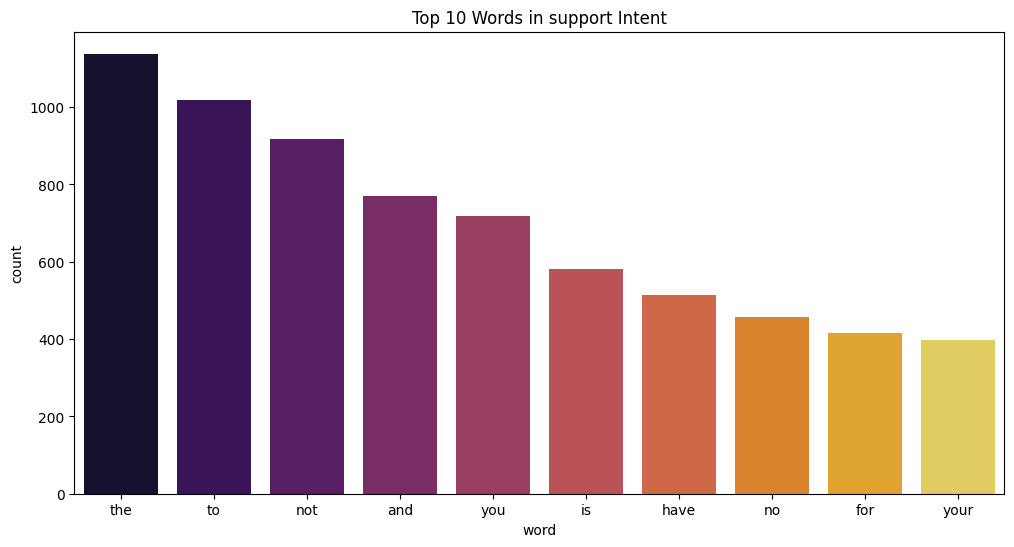

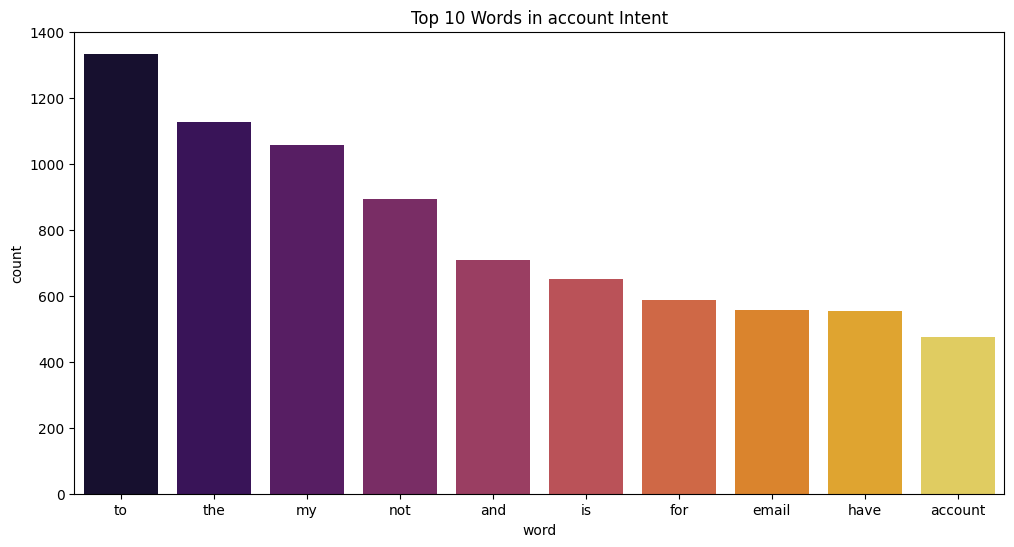

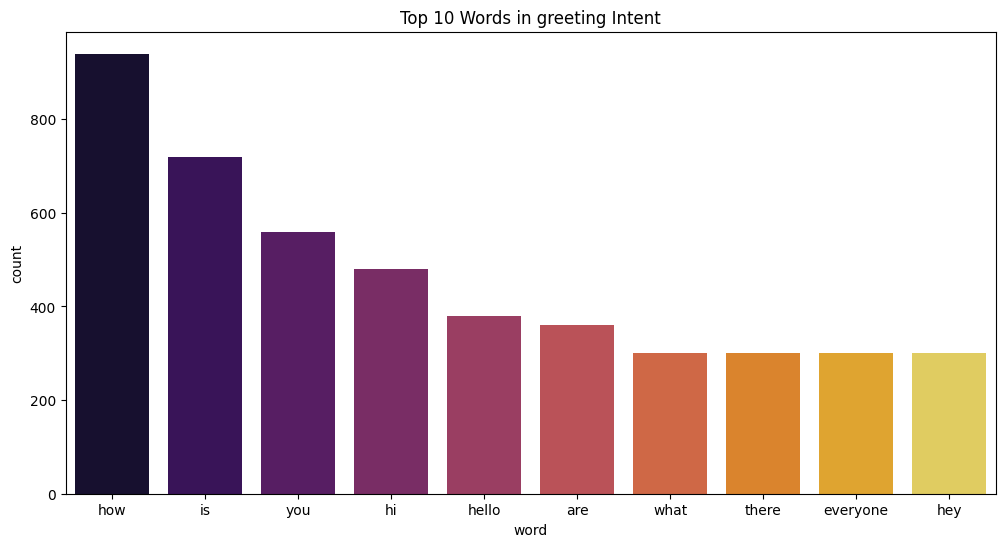

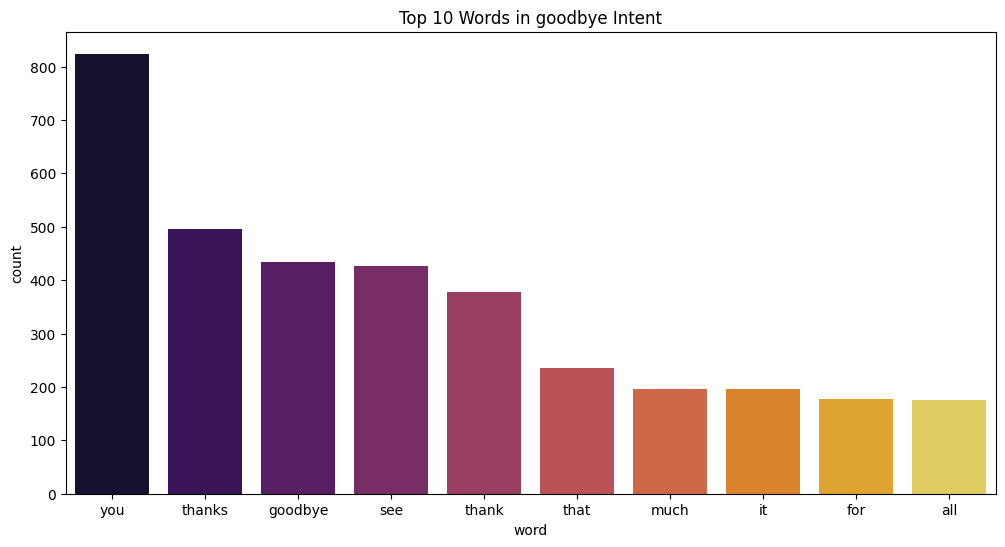

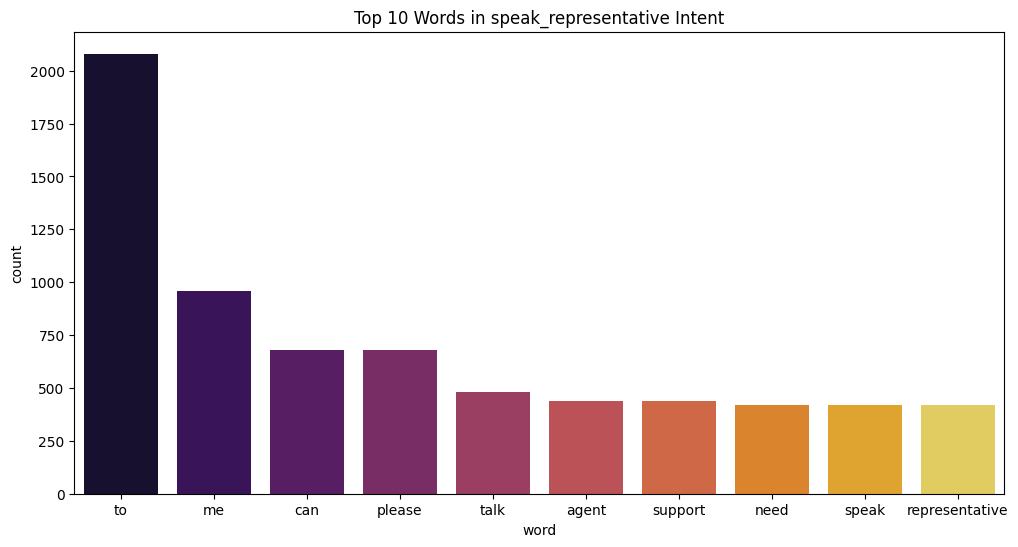

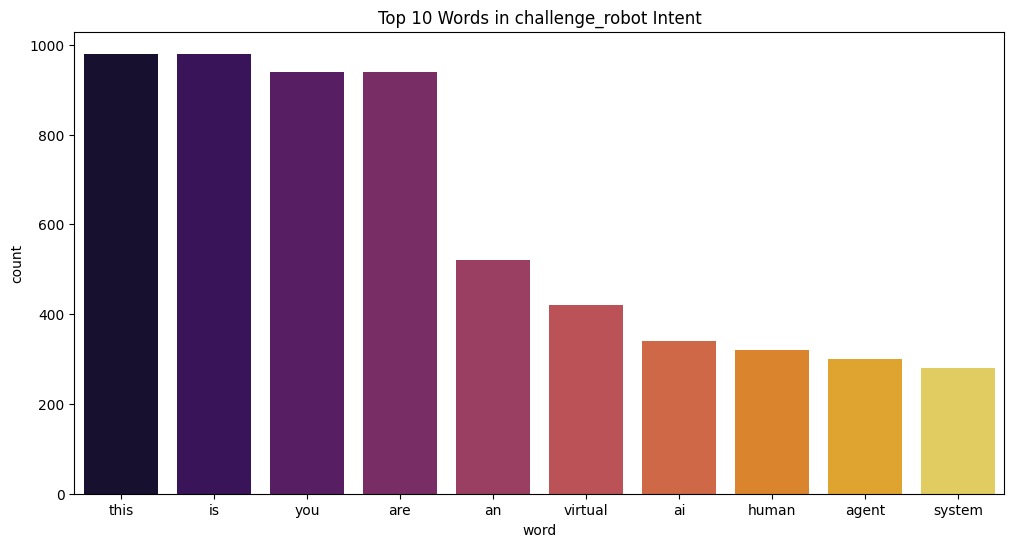

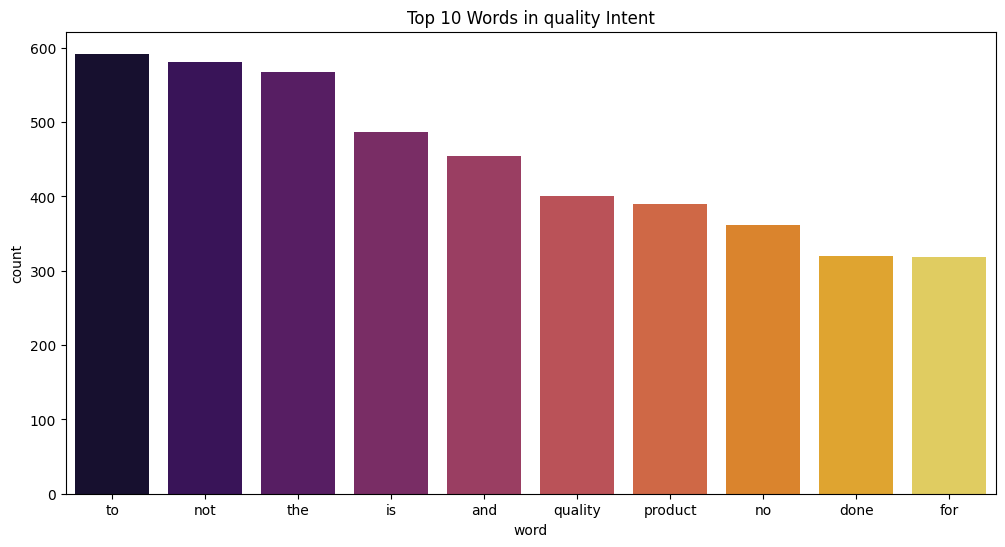

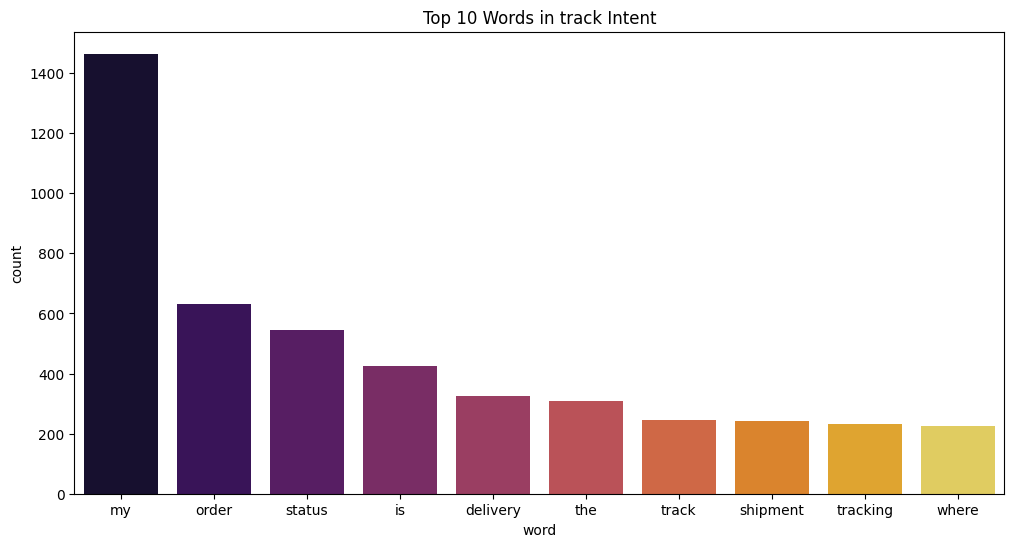

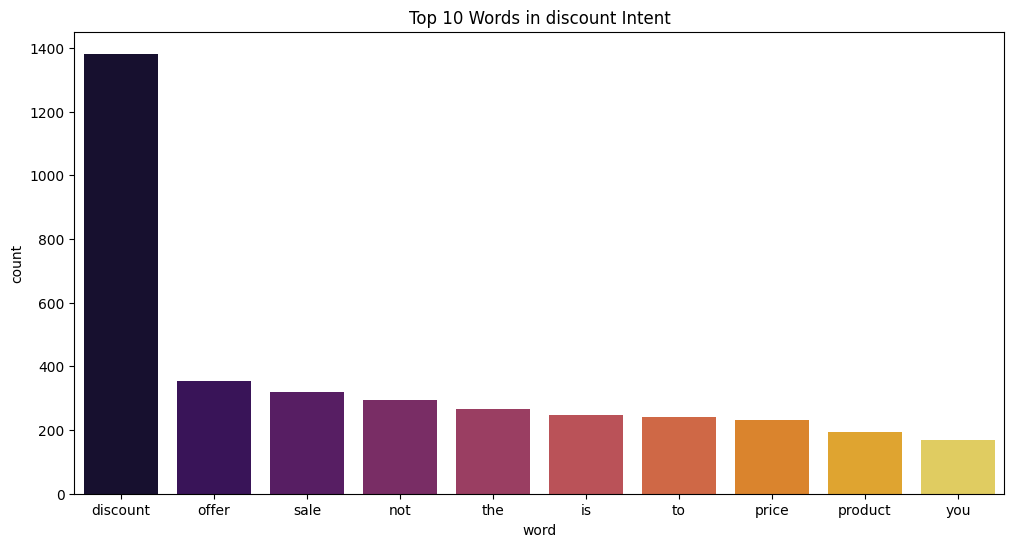

In [101]:
# Doing my bucket evaluations here - seeing what each distinct bucket intent means
for i in train.columns:
    top10_bagofwords(train[i].apply(" ".join), f'bucket_eval/{i}', f'Top 10 Words in {i} Intent')

In [36]:
wordranks.keys()

dict_keys([])

In [38]:
# Investigating bag of word frequencies at a more granular level
# wordranks["bucket_eval/speak_representative"].head(50)

In [104]:
# Flatten the list of all values and count occurences 
from collections import Counter 
all_vals = [val for vals in wordranks.values() for val in vals]
value_counts = Counter(all_vals)

# Filter values that appear in more than one key 
values_in_multiple_keys = {value for value, count in value_counts.items() if count > 1}

# Print the filtered values 
print(values_in_multiple_keys)

{'count', 'word'}


: 

**Here I can see there are only two values which are shared across any two keys. So it thinks good level of preprocessing has been achieved in identifying and segregating keys** 

In [86]:
[*train.columns]

['track',
 'support',
 'quality',
 'discount',
 'account',
 'speak_representative',
 'greeting',
 'goodbye',
 'challenge_robot']

### Generating text file for RASA 
Rasa API requires this format of data to be inputted into their bot. I work with my own training data in train, however this was made for experimenting with their tool.

In [28]:
#TODO: Will do this later

**Overview of Spacy's Scattertext Tool** 
- Scattertext is an advanced tool from Spacy that helps in identifying and visualizing distinguishing terms in small to medium-sized text datasets. It generates interactive scatter plots with clear, non-overlapping labels, making it an effective tool for exploratory data analysis (EDA). This visualization facilitates a better understanding of term distribution and relevance across different categories within the corpus.

**Capabilities of Scattertext**: 

- **Highlighting Distinctive Terms**: It identifies and highlights terms that are unique or prevalent in specific categories of the text data.
- **Interactive Visualizations**: The tool creates dynamic scatter plots that users can interact with, providing a more in-depth analysis.
- **Clear Labeling**: The tool ensures that term labels on the scatter plot do not overlap, which enhances readability and clarity. According to the documentation, Scattertext is "a tool for finding distinguishing terms in small-to-medium-sized corpora, and presenting them in a sexy, interactive scatter plot with non-overlapping term labels."

In [75]:
def term_freqs(intent_name, data):

    bagofwords = CountVectorizer()
    # Output will be a sparse matrix 
    inbound = bagofwords.fit_transform(data[data["Intent"] == intent_name]["Utterance"])
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    return words_rank

update_df = term_freqs('update')
repair_df = term_freqs('repair')

combined = pd.concat([update_df, repair_df], axis = 0)

TypeError: term_freqs() missing 1 required positional argument: 'data'

In [ ]:
#TODO: Will do this later